In [1]:
# Install package for natural language processing
%pip install --quiet nltk

# data manipulation
import pandas as pd
import numpy as np
import os

# text analysis tools
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from nltk import SnowballStemmer
import string

Note: you may need to restart the kernel to use updated packages.


In [2]:
data = pd.read_excel("Google Review Version2.xlsx")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
data.head()

,title,href,score,location,lat,lon,review_content,review_time,create_time
0,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59
1,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59
2,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59
3,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59
4,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59


In [4]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [8]:
dallas = gpd.read_file('01_City_Geo.geojson')
dallas = dallas.to_crs("EPSG:4326")
dallas = dallas[['GEOID', 'geometry']]

In [100]:
review_data = dallas
review_num = [0 for i in range(len(review_data))]
original_geo_data = gpd.GeoDataFrame(data)
original_geo_data["geometry"]= gpd.GeoDataFrame(geometry=gpd.points_from_xy(data["lat"],data["lon"]))
for i,row in original_geo_data.iterrows():
    point = row["geometry"]
    if len(review_data[review_data.intersects(point)]) != 0:
        temp_series = review_data.intersects(point)
        this_index = temp_series[temp_series].index[0]
        review_num[this_index] += 1
review_data["review_num"] = review_num

In [101]:
review_data.head()

,GEOID,geometry,review_num
0,48113010704,"MULTIPOLYGON (((-96.91997 32.73133, -96.91983 ...",60
1,48113006501,"MULTIPOLYGON (((-96.89847 32.73125, -96.89814 ...",0
2,48113006700,"MULTIPOLYGON (((-96.90339 32.74846, -96.90332 ...",23
3,48113010701,"MULTIPOLYGON (((-96.92601 32.75312, -96.92586 ...",70
4,48113019900,"MULTIPOLYGON (((-96.89848 32.73454, -96.89844 ...",0


/opt/anaconda3/envs/mypytorch/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/anaconda3/envs/mypytorch/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

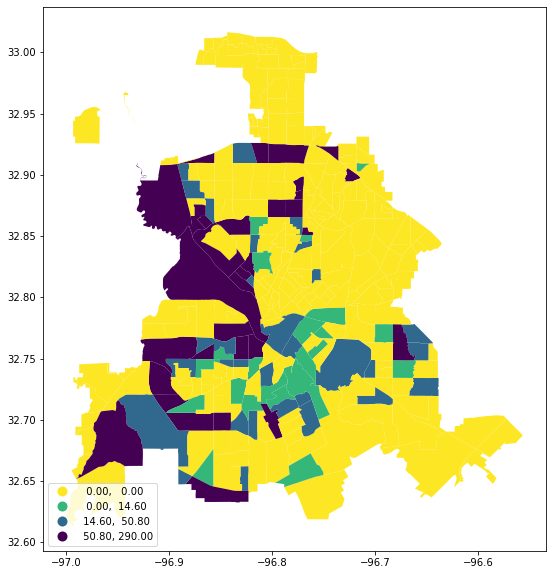

In [102]:
review_data.plot(column='review_num', legend=True, figsize=(20,10),k=10, scheme='Quantiles'
           , legend_kwds={'loc': 'lower left'}, cmap='viridis_r')

In [10]:
def find_multi(point):
    if len(dallas[dallas.intersects(point)]) != 0:
        return dallas[dallas.intersects(point)].iloc[0]["geometry"]
    else:
        return point

In [11]:
data.columns

Index(['title', 'href', 'score', 'location', 'lat', 'lon', 'review_content',
       'review_time', 'create_time'],
      dtype='object')

In [12]:
# some basic descriptive analytics on data

# converting to geo data and plotting choropleth
# plotting a temporal graph
# plotting by stop reason
# plotting by race
# stopped vs person arrested flag based on race; space
 

In [13]:
data['review_content'].value_counts()

Good                                                                                                                                                                                                                                                 9
Nice                                                                                                                                                                                                                                                 7
Ok                                                                                                                                                                                                                                                   5
Everything is always so clean and comfortable! The staff are always extremely welcoming and hospitable! I love this place!                                                                                                                           3
Beautiful   

In [14]:
data['review_content_low']=data['review_content'].str.lower()
data['review_content_low'].head()

0    this will be my home for a long time thanks to...
1    apartment hunting is stressful and you never r...
2    i have lived at lakeside lofts for over a year...
3    i was a resident of this complex for 14 months...
4    i really love and enjoy the views, the walk ar...
Name: review_content_low, dtype: object

In [15]:
#5.8 Defining set containing all stopwords in English
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'get', 'xyz', 'friendly','staff','management','pet','park']

In [16]:
#5.9 Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [17]:
data['review_content_low'] = data['review_content_low'].apply(lambda text: cleaning_stopwords(text))
data['review_content_low'].head()

0    home long time thanks community area pools! ev...
1    apartment hunting stressful never really know ...
2    lived lakeside lofts over year & plan renewing...
3    resident complex 14 months first moved i. nice...
4    really love enjoy views, walk around lake, 3 p...
Name: review_content_low, dtype: object

In [18]:
#5.11 Cleaning and removing repeating characters
import re
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

In [19]:
data['review_content_low'] = data['review_content_low'].apply(lambda x: cleaning_repeating_char(x))
data['review_content_low'].tail()

4830    husband little over week love it. christy nanc...
4831    amazing ! ladies willing work issues maintenan...
4832    team bias - hispanic, apartment not, beware! p...
4833    mailbox keeps getting broken i’ve pay fixed al...
4834    got mugged here. resident so, parked car got d...
Name: review_content_low, dtype: object

In [20]:
#5.13 Cleaning and removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['review_content_low'] = data['review_content_low'].apply(lambda x: cleaning_numbers(x))
data['review_content_low'].tail()

4830    husband little over week love it. christy nanc...
4831    amazing ! ladies willing work issues maintenan...
4832    team bias - hispanic, apartment not, beware! p...
4833    mailbox keeps getting broken i’ve pay fixed al...
4834    got mugged here. resident so, parked car got d...
Name: review_content_low, dtype: object

In [21]:
#5.15 Applying Stemming - this is a process of retaining just the core meaning of the word 
# enaxple - comforting to comfort
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data['review_content_low']= data['review_content_low'].apply(lambda x: stemming_on_text(x))
data['review_content_low'].head()

0    home long time thanks community area pools! ev...
1    apartment hunting stressful never really know ...
2    lived lakeside lofts over year & plan renewing...
3    resident complex months first moved i. nice qu...
4    really love enjoy views, walk around lake,  po...
Name: review_content_low, dtype: object

In [22]:
!pip install nltk

In [23]:
#5.16 Applying Lemmatizer (https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data['review_content_low']  = data['review_content_low'] .apply(lambda x: lemmatizer_on_text(x))
data['review_content_low'] .tail()

[nltk_data] Error loading omw-1.4: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>


4830    husband little over week love it. christy nanc...
4831    amazing ! ladies willing work issues maintenan...
4832    team bias - hispanic, apartment not, beware! p...
4833    mailbox keeps getting broken i’ve pay fixed al...
4834    got mugged here. resident so, parked car got d...
Name: review_content_low, dtype: object

In [24]:
#5.14 Getting tokenization of tweet text
def tokenize(data):
    return [x for x in re.split(r"([.,!?]+)?\s+", data) if x]
#from nltk.tokenize import RegexpTokenizer
#tokenizer = RegexpTokenizer(r'w+')
data['review_content_low'] = data['review_content_low'].apply(lambda x: tokenize(x))
data['review_content_low'].tail()

4830    [husband, little, over, week, love, it, ., chr...
4831    [amazing, !, ladies, willing, work, issues, ma...
4832    [team, bias, -, hispanic, ,, apartment, not, ,...
4833    [mailbox, keeps, getting, broken, i’ve, pay, f...
4834    [got, mugged, here, ., resident, so, ,, parked...
Name: review_content_low, dtype: object

In [25]:
token_data = data.copy()

In [26]:
token_data['review_content_low']

0       [home, long, time, thanks, community, area, po...
1       [apartment, hunting, stressful, never, really,...
2       [lived, lakeside, lofts, over, year, &, plan, ...
3       [resident, complex, months, first, moved, i, ....
4       [really, love, enjoy, views, ,, walk, around, ...
                              ...                        
4830    [husband, little, over, week, love, it, ., chr...
4831    [amazing, !, ladies, willing, work, issues, ma...
4832    [team, bias, -, hispanic, ,, apartment, not, ,...
4833    [mailbox, keeps, getting, broken, i’ve, pay, f...
4834    [got, mugged, here, ., resident, so, ,, parked...
Name: review_content_low, Length: 4835, dtype: object

In [27]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [28]:
sid = SentimentIntensityAnalyzer()
token_data['score'] = token_data['review_content_low'].apply(lambda text: sid.polarity_scores(text))
token_data['final_score']  = token_data['score'].apply(lambda score_dict: score_dict['compound'])

In [29]:
token_data[token_data['final_score'] == token_data['final_score'].min()]

,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,final_score
1724,The Burgundy Apartments,https://www.google.com/maps/search/The+Burgund...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","11911 Marsh Ln, Dallas, TX 75234, United States",-96.85833,32.911344,Hated it,get time error,2022-05-03 17:31:59,[hated],-0.6369


In [30]:
sanitize = token_data.review_content_low == 'nan'

In [31]:
token_data = token_data[sanitize==False]

In [32]:
token_data.head()

,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,final_score
0,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59,"[home, long, time, thanks, community, area, po...",0.0
1,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59,"[apartment, hunting, stressful, never, really,...",0.0
2,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59,"[lived, lakeside, lofts, over, year, &, plan, ...",0.0
3,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59,"[resident, complex, months, first, moved, i, ....",0.0
4,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59,"[really, love, enjoy, views, ,, walk, around, ...",0.0


In [33]:
token_data_plot = gpd.GeoDataFrame(token_data)
token_data_plot["geometry"]= gpd.GeoDataFrame(geometry=gpd.points_from_xy(token_data_plot["lat"],token_data_plot["lon"]))
token_data_plot["geometry"] = token_data_plot["geometry"].apply(find_multi)
token_data_plot.head()

/opt/anaconda3/envs/mypytorch/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,final_score,geometry
0,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59,"[home, long, time, thanks, community, area, po...",0.0,POINT (-96.92375 32.90169)
1,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59,"[apartment, hunting, stressful, never, really,...",0.0,POINT (-96.92375 32.90169)
2,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59,"[lived, lakeside, lofts, over, year, &, plan, ...",0.0,POINT (-96.92375 32.90169)
3,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59,"[resident, complex, months, first, moved, i, ....",0.0,POINT (-96.92375 32.90169)
4,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59,"[really, love, enjoy, views, ,, walk, around, ...",0.0,POINT (-96.92375 32.90169)


/opt/anaconda3/envs/mypytorch/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/anaconda3/envs/mypytorch/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

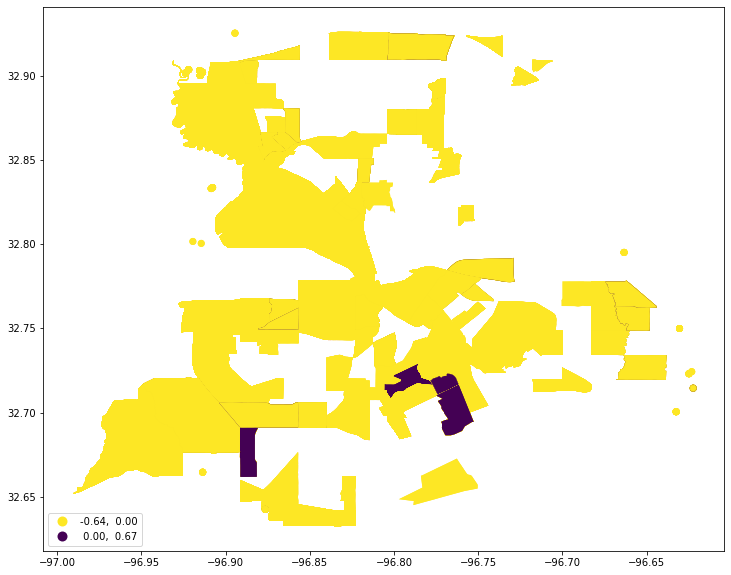

In [34]:
token_data_plot.plot(column='final_score', legend=True, figsize=(20,10),k=10, scheme='Quantiles'
           , legend_kwds={'loc': 'lower left'}, cmap='viridis_r')

In [35]:
token_data[token_data['final_score'] == token_data['final_score'].max()]

,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,final_score,geometry
289,Magnolia at West Lemmon,https://www.google.com/maps/search/Magnolia+at...,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","3383 Cedarplaza Ln, Dallas, TX 75235, United S...",-96.822356,32.825763,Staff is the best!,get time error,2022-05-03 17:31:59,[best!],0.6696,"MULTIPOLYGON (((-96.83123 32.82581, -96.83057 ..."
3957,Walker Place,https://www.google.com/maps/search/Walker+Plac...,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","3880 S Walton Walker Blvd, Dallas, TX 75236, U...",-96.894008,32.697430,Love!,get time error,2022-05-03 17:31:59,[love!],0.6696,"MULTIPOLYGON (((-96.90394 32.70585, -96.90376 ..."


(array([4.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 4.767e+03, 0.000e+00,
        2.000e+00, 1.400e+01, 2.500e+01, 1.700e+01]),
 array([-0.6369 , -0.50625, -0.3756 , -0.24495, -0.1143 ,  0.01635,
         0.147  ,  0.27765,  0.4083 ,  0.53895,  0.6696 ]),
 <BarContainer object of 10 artists>)

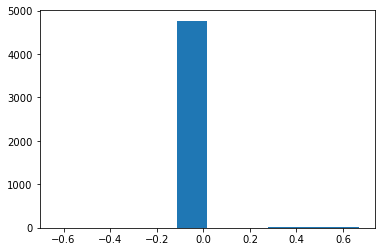

In [36]:
import matplotlib.pyplot as plt
token_data_x = token_data[['final_score']]
plt.hist(token_data_x)

In [37]:
# trying different type of stemming to ctrate bag of words )
stemmer = SnowballStemmer("english")
print(stemmer.stem('lies')) #just an example

lie


In [38]:
#this is to remove punctuation 
translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

In [39]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
# ursing orininal datafeame here on not the one that was filtered for sentiment analysis)
token_data.head()

,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,final_score,geometry
0,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59,"[home, long, time, thanks, community, area, po...",0.0,POINT (-96.92375 32.90169)
1,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59,"[apartment, hunting, stressful, never, really,...",0.0,POINT (-96.92375 32.90169)
2,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59,"[lived, lakeside, lofts, over, year, &, plan, ...",0.0,POINT (-96.92375 32.90169)
3,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59,"[resident, complex, months, first, moved, i, ....",0.0,POINT (-96.92375 32.90169)
4,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59,"[really, love, enjoy, views, ,, walk, around, ...",0.0,POINT (-96.92375 32.90169)


In [41]:
# creating a list of reviews
review_list = token_data['review_content'].values.tolist()

In [42]:
#look at first review
review_list[0]

'This will be my home for a long time thanks to the Community Area and the Pools! Even after a big TX Storm in the night the Maintenance crew cleaned next day and it was like it never happened.\nGreat place to be in my Humble Opinion.'

In [43]:
#We want to separate text into individual tokens (generally individual words). To do this, we will first write a function that takes a string and splits it up into individual words.
review_list[0].split()[:10]

['This', 'will', 'be', 'my', 'home', 'for', 'a', 'long', 'time', 'thanks']

In [44]:
def tokenize(text):
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))  # translator that replaces punctuation with empty spaces
    return [stemmer.stem(i) for i in text.translate(translator).split()]  # stemmer and tokenizing into words

In [45]:
tokenize(review_list[0])

['this',
 'will',
 'be',
 'my',
 'home',
 'for',
 'a',
 'long',
 'time',
 'thank',
 'to',
 'the',
 'communiti',
 'area',
 'and',
 'the',
 'pool',
 'even',
 'after',
 'a',
 'big',
 'tx',
 'storm',
 'in',
 'the',
 'night',
 'the',
 'mainten',
 'crew',
 'clean',
 'next',
 'day',
 'and',
 'it',
 'was',
 'like',
 'it',
 'never',
 'happen',
 'great',
 'place',
 'to',
 'be',
 'in',
 'my',
 'humbl',
 'opinion']

In [46]:
# We download stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>


False

In [47]:
# Set the correct stop words
stop_words = set(stopwords.words('english'))

In [48]:
# Tokenize stop words to match 
stop_words = [tokenize(s)[0] for s in stop_words]

In [49]:
# Create Vectorizer
vectorizer = CountVectorizer(analyzer="word",           # unit of features are single words rather than characters
                            tokenizer=tokenize,         # function to create tokens
                            ngram_range=(0,1),          # unigrams - single words
                            strip_accents='unicode',    # remove accent characters
                            stop_words = stop_words,    # remove stopwords
                            min_df = 0.05,              # only include words with minimum frequency of 0.05
                            max_df = 0.95)              # only include words with maximum frequency of 0.95

# Creating bag of words
bag_of_words = vectorizer.fit_transform(review_list) # transform our corpus as a bag of words
features = vectorizer.get_feature_names()               # get features (words)

# Fitting LDA model
# Here we change number of topics to 5 topics
# n_components = 5

lda = LatentDirichletAllocation(n_components = 5, learning_method='online')
doctopic = lda.fit_transform(bag_of_words)

# Displaying the top keywords in each topic
ls_keywords = []
for i,topic in enumerate(lda.components_):
    word_idx = np.argsort(topic)[::-1][:5]
    keywords = ', '.join(features[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)

/opt/anaconda3/envs/mypytorch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0 manag, properti, park, new, resid
1 great, help, good, apart, communiti
2 offic, alway, staff, complex, mainten
3 live, place, year, love, one
4 move, apart, experi, get, day


In [50]:
bag_of_words_df = pd.DataFrame(bag_of_words.todense(), columns=features)

In [51]:
bag_of_words_df

,alway,amaz,apart,call,care,clean,communiti,complex,day,even,...,recommend,resid,say,staff,thing,time,well,work,would,year
0,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4831,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4832,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4833,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#viewing top 10 words in 10 topics
ls_keywords = []
for i,topic in enumerate(lda.components_):  # lda.components_ represent topics
    word_idx = np.argsort(topic)[::-1][:10]
    keywords = ', '.join(features[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)

0 manag, properti, park, new, resid, care, get, issu, work, year
1 great, help, good, apart, communiti, staff, love, locat, nice, move
2 offic, alway, staff, complex, mainten, friend, apart, leas, call, live
3 live, place, year, love, one, recommend, look, nice, like, clean
4 move, apart, experi, get, day, say, month, first, like, work


In [53]:
# A score is assigned to each of the topic (the higher the score, the more likely the abstract belongs to that topic)
pd.DataFrame(doctopic, columns = ls_keywords)

,"manag, properti, park, new, resid, care, get, issu, work, year","great, help, good, apart, communiti, staff, love, locat, nice, move","offic, alway, staff, complex, mainten, friend, apart, leas, call, live","live, place, year, love, one, recommend, look, nice, like, clean","move, apart, experi, get, day, say, month, first, like, work"
0,0.018276,0.220398,0.163054,0.190386,0.407887
1,0.022311,0.022405,0.022355,0.022471,0.910458
2,0.180190,0.017301,0.570540,0.215204,0.016765
3,0.015944,0.015534,0.461646,0.016026,0.490849
4,0.020105,0.020650,0.625000,0.314067,0.020177
...,...,...,...,...,...
4830,0.028839,0.029511,0.883630,0.029103,0.028917
4831,0.269038,0.018608,0.675152,0.018322,0.018879
4832,0.506210,0.033708,0.033856,0.191670,0.234555
4833,0.897680,0.025642,0.025072,0.025648,0.025957


In [54]:
topics_reviews = pd.DataFrame(doctopic, columns = ls_keywords)

In [55]:
topics_reviews.head()

,"manag, properti, park, new, resid, care, get, issu, work, year","great, help, good, apart, communiti, staff, love, locat, nice, move","offic, alway, staff, complex, mainten, friend, apart, leas, call, live","live, place, year, love, one, recommend, look, nice, like, clean","move, apart, experi, get, day, say, month, first, like, work"
0,0.018276,0.220398,0.163054,0.190386,0.407887
1,0.022311,0.022405,0.022355,0.022471,0.910458
2,0.180190,0.017301,0.570540,0.215204,0.016765
3,0.015944,0.015534,0.461646,0.016026,0.490849
4,0.020105,0.020650,0.625000,0.314067,0.020177


In [56]:
# Idxmax function and axis=1: return the column name of the max value in a row
topics_reviews.idxmax(axis=1)

0       move, apart, experi, get, day, say, month, fir...
1       move, apart, experi, get, day, say, month, fir...
2       offic, alway, staff, complex, mainten, friend,...
3       move, apart, experi, get, day, say, month, fir...
4       offic, alway, staff, complex, mainten, friend,...
                              ...                        
4830    offic, alway, staff, complex, mainten, friend,...
4831    offic, alway, staff, complex, mainten, friend,...
4832    manag, properti, park, new, resid, care, get, ...
4833    manag, properti, park, new, resid, care, get, ...
4834    manag, properti, park, new, resid, care, get, ...
Length: 4835, dtype: object

In [57]:
reviews_filter = pd.concat([topics_reviews.idxmax(axis=1),token_data],axis=1).rename(columns={0:'topic'})

In [58]:
reviews_filter.shape

(4835, 13)

In [59]:
reviews_filter.head()

,topic,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,final_score,geometry
0,"move, apart, experi, get, day, say, month, fir...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59,"[home, long, time, thanks, community, area, po...",0.0,POINT (-96.92375 32.90169)
1,"move, apart, experi, get, day, say, month, fir...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59,"[apartment, hunting, stressful, never, really,...",0.0,POINT (-96.92375 32.90169)
2,"offic, alway, staff, complex, mainten, friend,...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59,"[lived, lakeside, lofts, over, year, &, plan, ...",0.0,POINT (-96.92375 32.90169)
3,"move, apart, experi, get, day, say, month, fir...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59,"[resident, complex, months, first, moved, i, ....",0.0,POINT (-96.92375 32.90169)
4,"offic, alway, staff, complex, mainten, friend,...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59,"[really, love, enjoy, views, ,, walk, around, ...",0.0,POINT (-96.92375 32.90169)


In [60]:
aa = reviews_filter
aa['final_score'] = aa['final_score']*9 + 1

In [61]:
aa

,topic,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,final_score,geometry
0,"move, apart, experi, get, day, say, month, fir...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59,"[home, long, time, thanks, community, area, po...",1.0,POINT (-96.92375 32.90169)
1,"move, apart, experi, get, day, say, month, fir...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59,"[apartment, hunting, stressful, never, really,...",1.0,POINT (-96.92375 32.90169)
2,"offic, alway, staff, complex, mainten, friend,...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59,"[lived, lakeside, lofts, over, year, &, plan, ...",1.0,POINT (-96.92375 32.90169)
3,"move, apart, experi, get, day, say, month, fir...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59,"[resident, complex, months, first, moved, i, ....",1.0,POINT (-96.92375 32.90169)
4,"offic, alway, staff, complex, mainten, friend,...",Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59,"[really, love, enjoy, views, ,, walk, around, ...",1.0,POINT (-96.92375 32.90169)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,"offic, alway, staff, complex, mainten, friend,...",Chesapeake,"https://www.google.com/maps/search/Chesapeake,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,My husband and I have been here a little over ...,get time error,2022-05-03 17:31:59,"[husband, little, over, week, love, it, ., chr...",1.0,"MULTIPOLYGON (((-96.71789 32.90955, -96.71773 ..."
4831,"offic, alway, staff, complex, mainten, friend,...",Chesapeake,"https://www.google.com/maps/search/Chesapeake,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,Management staff is amazing ! The ladies are w...,get time error,2022-05-03 17:31:59,"[amazing, !, ladies, willing, work, issues, ma...",1.0,"MULTIPOLYGON (((-96.71789 32.90955, -96.71773 ..."
4832,"manag, properti, park, new, resid, care, get, ...",Chesapeake,"https://www.google.com/maps/search/Chesapeake,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,Management team very bias - if you are Hispani...,get time error,2022-05-03 17:31:59,"[team, bias, -, hispanic, ,, apartment, not, ,...",1.0,"MULTIPOLYGON (((-96.71789 32.90955, -96.71773 ..."
4833,"manag, properti, park, new, resid, care, get, ...",Chesapeake,"https://www.google.com/maps/search/Chesapeake,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,My mailbox keeps getting broken into and I’ve ...,get time error,2022-05-03 17:31:59,"[mailbox, keeps, getting, broken, i’ve, pay, f...",1.0,"MULTIPOLYGON (((-96.71789 32.90955, -96.71773 ..."


array([[<AxesSubplot:title={'center':'final_score'}>]], dtype=object)

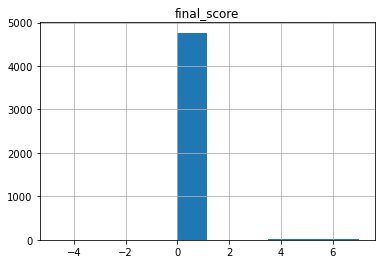

In [62]:
aa.hist(column='final_score')

# This is  done for all reviews just as a trial. To get relavant reviews we need to select specific words(could also be adjectives) such as: mold, plumbing, broken etc. We can select the workds from the bag of words after we have the complete data. As of now the topic modeling as well as sentiment score is quite irrelavant expect a better reslut after we do the filtering.

In [63]:
reviews_filter.groupby(['final_score'])['location'].count()

final_score
-4.7321       1
-4.2434       1
-3.8807       1
-3.5954       1
-3.2903       3
-2.9636       2
-2.2508       1
 0.3052       1
 1.0000    4762
 3.0367       2
 3.6640       8
 3.8638       4
 4.2508       2
 4.7935       8
 4.9636      14
 5.2903       2
 5.5954       1
 6.2731       3
 6.3946       5
 6.6241       2
 6.7321       5
 7.0264       2
Name: location, dtype: int64

In [64]:
reviews_filter2=reviews_filter.groupby(['final_score'])['location'].count()

AttributeError: 'Rectangle' object has no property 'column'

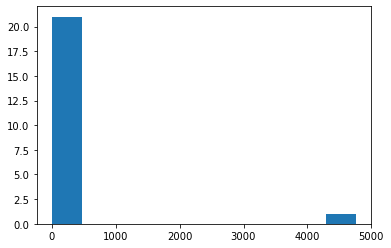

In [65]:
reviews_filter2.hist(column='final_score')

In [ ]:
reviews_filter2.reset_index()

In [ ]:
reviews_filter2.hist()

In [ ]:
reviews_filter2.plot(kind="hist",log=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
reviews_filter3= reviews_filter2.reset_index()

In [ ]:
plt.bar(reviews_filter3['final_score'],reviews_filter3['location'],0.1)
plt.xlabel('Score')
plt.ylabel('Num')

In [ ]:
data

In [66]:
data1 = data

In [67]:
new_min = 0
new_max = 10

score_min = data1['score'].min()
score_max = data1['score'].max()

In [68]:
data1['rank'] = ((data1['score'] - score_max)/(score_min - score_max)) * (new_max - new_min) + new_min

data1

#data2['plumbing_score'] = ((data2['plumbing_perc'] - plumbing_min)/(plumbing_max - plumbing_min)) * (new_max - new_min) + new_min

#data2



,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,rank
0,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59,"[home, long, time, thanks, community, area, po...",4.00
1,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59,"[apartment, hunting, stressful, never, really,...",4.00
2,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59,"[lived, lakeside, lofts, over, year, &, plan, ...",4.00
3,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59,"[resident, complex, months, first, moved, i, ....",4.00
4,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59,"[really, love, enjoy, views, ,, walk, around, ...",4.00
...,...,...,...,...,...,...,...,...,...,...,...
4830,Chesapeake,"https://www.google.com/maps/search/Chesapeake,...",2.3,"11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,My husband and I have been here a little over ...,get time error,2022-05-03 17:31:59,"[husband, little, over, week, love, it, ., chr...",6.75
4831,Chesapeake,"https://www.google.com/maps/search/Chesapeake,...",2.3,"11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,Management staff is amazing ! The ladies are w...,get time error,2022-05-03 17:31:59,"[amazing, !, ladies, willing, work, issues, ma...",6.75
4832,Chesapeake,"https://www.google.com/maps/search/Chesapeake,...",2.3,"11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,Management team very bias - if you are Hispani...,get time error,2022-05-03 17:31:59,"[team, bias, -, hispanic, ,, apartment, not, ,...",6.75
4833,Chesapeake,"https://www.google.com/maps/search/Chesapeake,...",2.3,"11620 Audelia Rd, Dallas, TX 75243, United States",-96.717304,32.907477,My mailbox keeps getting broken into and I’ve ...,get time error,2022-05-03 17:31:59,"[mailbox, keeps, getting, broken, i’ve, pay, f...",6.75


In [69]:
data1_plot = gpd.GeoDataFrame(data1)
data1_plot["geometry"]= gpd.GeoDataFrame(geometry=gpd.points_from_xy(data1_plot["lat"],data1_plot["lon"]))
data1_plot["geometry"] = data1_plot["geometry"].apply(find_multi)
data1_plot.head()

/opt/anaconda3/envs/mypytorch/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,title,href,score,location,lat,lon,review_content,review_time,create_time,review_content_low,rank,geometry
0,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,This will be my home for a long time thanks to...,get time error,2022-05-03 17:31:59,"[home, long, time, thanks, community, area, po...",4.0,POINT (-96.92375 32.90169)
1,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,Apartment hunting is stressful and you never r...,get time error,2022-05-03 17:31:59,"[apartment, hunting, stressful, never, really,...",4.0,POINT (-96.92375 32.90169)
2,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I have lived at Lakeside Lofts for over a year...,get time error,2022-05-03 17:31:59,"[lived, lakeside, lofts, over, year, &, plan, ...",4.0,POINT (-96.92375 32.90169)
3,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,I was a resident of this complex for 14 months...,get time error,2022-05-03 17:31:59,"[resident, complex, months, first, moved, i, ....",4.0,POINT (-96.92375 32.90169)
4,Lakeside Lofts,https://www.google.com/maps/search/Lakeside+Lo...,3.4,"11500 Lago Vista E, Farmers Branch, TX 75234, ...",-96.923746,32.901693,"I really love and enjoy the views, the walk ar...",get time error,2022-05-03 17:31:59,"[really, love, enjoy, views, ,, walk, around, ...",4.0,POINT (-96.92375 32.90169)


<AxesSubplot:>

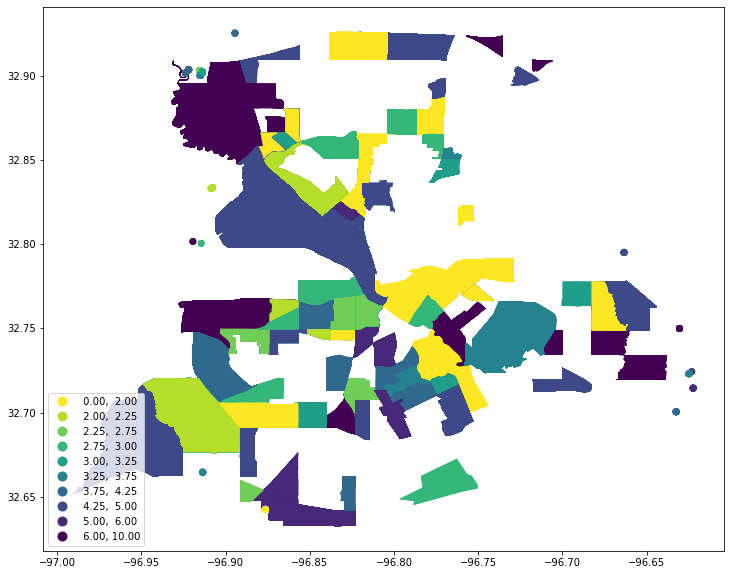

In [70]:
data1_plot.plot(column='rank', legend=True, figsize=(20,10),k=10, scheme='Quantiles'
           , legend_kwds={'loc': 'lower left'}, cmap='viridis_r')

array([[<AxesSubplot:title={'center':'rank'}>]], dtype=object)

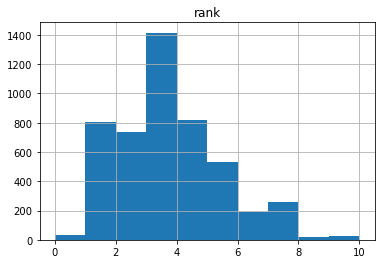

In [71]:
data1.hist(column='rank')

In [76]:
pip install geopandas
pip install geopy

SyntaxError: invalid syntax (<ipython-input-76-26ae6b0c7caa>, line 1)

In [ ]:
df = pd.read_csv(“addresses.csv”)
df.head()

In [ ]:
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df['location'] = df['ADDRESS'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index

SyntaxError: ignored